# PU rejection BDT HLS implementation

In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)


def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '12',
    'date'       : '2022_10_04',
    'inTag'      : '_lTauPtCut18_lEtacut1.5',
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauBDTIdentifierTraining'+options['inTag']
calibdir = indir+'/TauBDTCalibratorTraining'+options['inTag']

In [4]:
Xident = pd.read_pickle(identdir+'/X_Ident_BDT_forEvaluator.pkl')
Xcalib = pd.read_pickle(calibdir+'/X_Calib_BDT_forEvaluator.pkl')

IDfeats  = ['cl3d_localAbsEta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_seetot', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_localAbsMeanZ']
CALfeats = ['cl3d_pt', 'cl3d_localAbsEta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_seetot', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_localAbsMeanZ']

scalerIdent = StandardScaler()
scaledIdent = pd.DataFrame(scalerIdent.fit_transform(Xident[IDfeats]), columns=IDfeats)

scalerCalib = StandardScaler()
scaledCalib = pd.DataFrame(scalerCalib.fit_transform(Xcalib[CALfeats]), columns=CALfeats)

TensorizedInputIdent  = scaledIdent[IDfeats].to_numpy()
TensorizedInputCalib  = scaledCalib[CALfeats].to_numpy()

TensorizedTargetIdent = Xident['targetId'].to_numpy()
TensorizedTargetCalib = Xcalib['tau_visPt'].to_numpy()

TensorizedInputIdent_reduced = TensorizedInputIdent[:3000]
TensorizedInputCalib_reduced = TensorizedInputCalib[:3000]

TensorizedTargetIdent_reduced = TensorizedTargetIdent[:3000].reshape(-1,1)
TensorizedTargetCalib_reduced = TensorizedTargetCalib[:3000].reshape(-1,1)

In [15]:
identdir = indir+'/TauDNNIdentifierTraining'+options['inTag']
calibdir = indir+'/TauDNNCalibratorTraining'+options['inTag']

# quantized models
QDNNident = keras.models.load_model(identdir+'/TauQDNNIdentifier', compile=False)
QDNNcalib = keras.models.load_model(calibdir+'/TauQDNNCalibrator', compile=False)

# full models
DNNident_FullFloat = keras.models.load_model(identdir+'/TauDNNIdentifier', compile=False)
DNNcalib_FullFloat = keras.models.load_model(calibdir+'/TauDNNCalibrator', compile=False)

## Create HLS model for the identification DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CL3DFeatures, layer type: Input
Layer name: DNNlayer, layer type: QDense
  -> Activation (linear), layer name: DNNlayer
Layer name: RELU_DNNlayer, layer type: QActivation
  -> Activation (quantized_relu(16,6)), layer name: RELU_DNNlayer
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CL3DFeatures': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<10,7>', 'accum': 'ap_fixed<13,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Strategy': 'Resources', 'Trace': True}, 'RELU_DNNlayer': {'Precision': 'ap_fixed<9,5>', 'Reuse

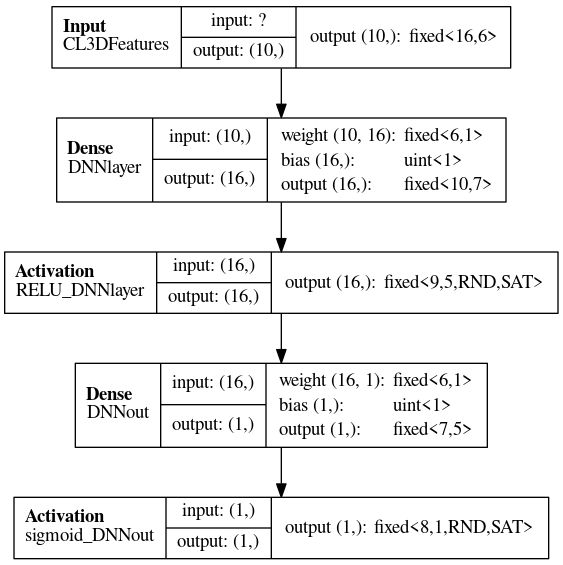

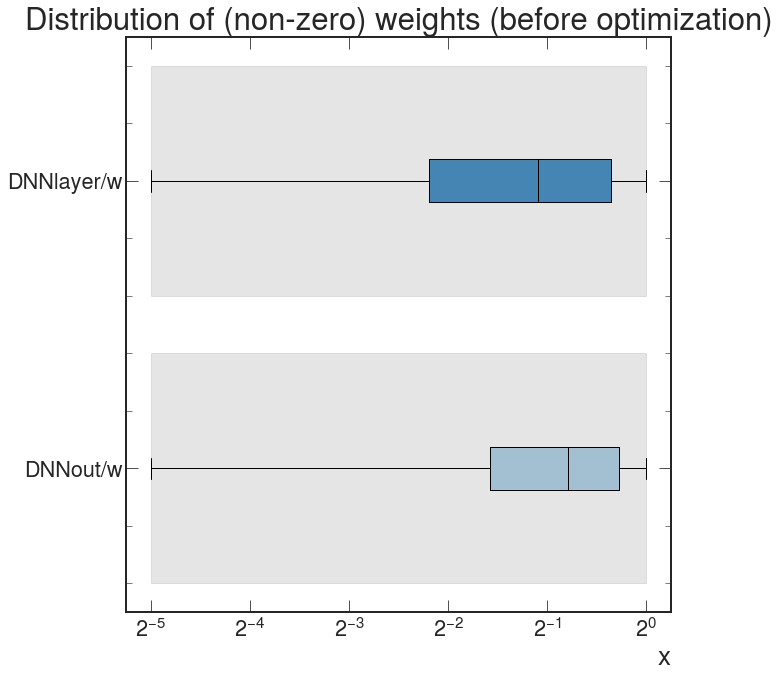

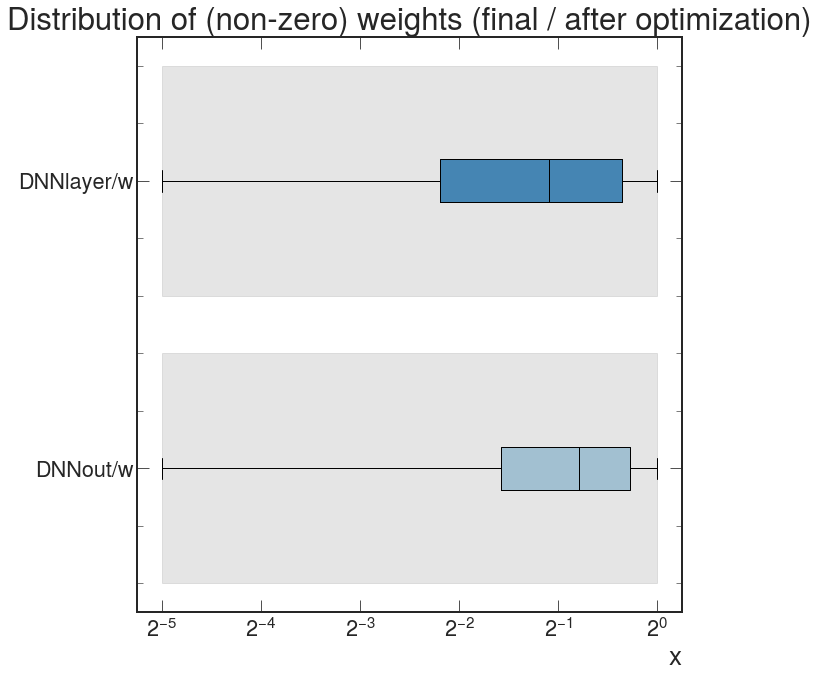

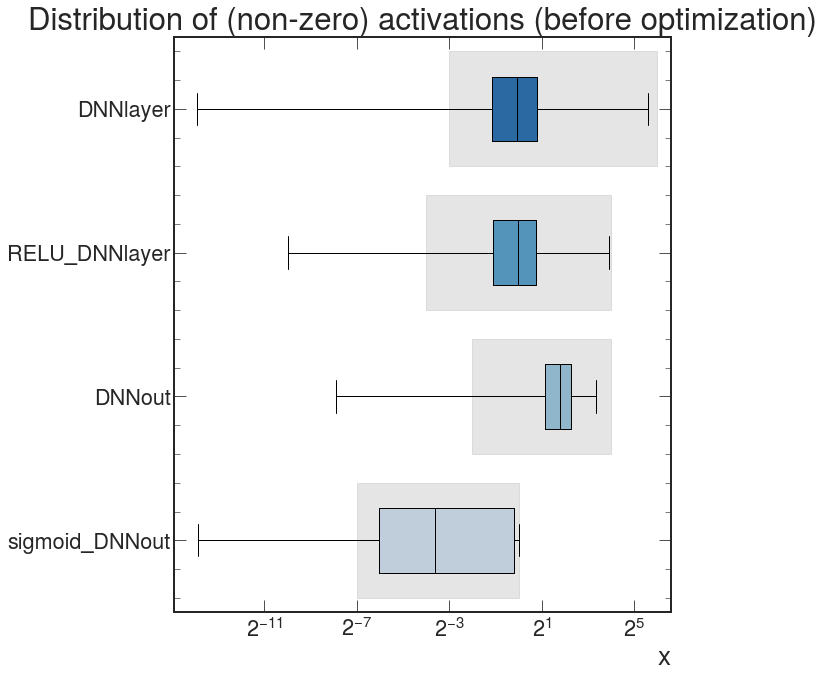

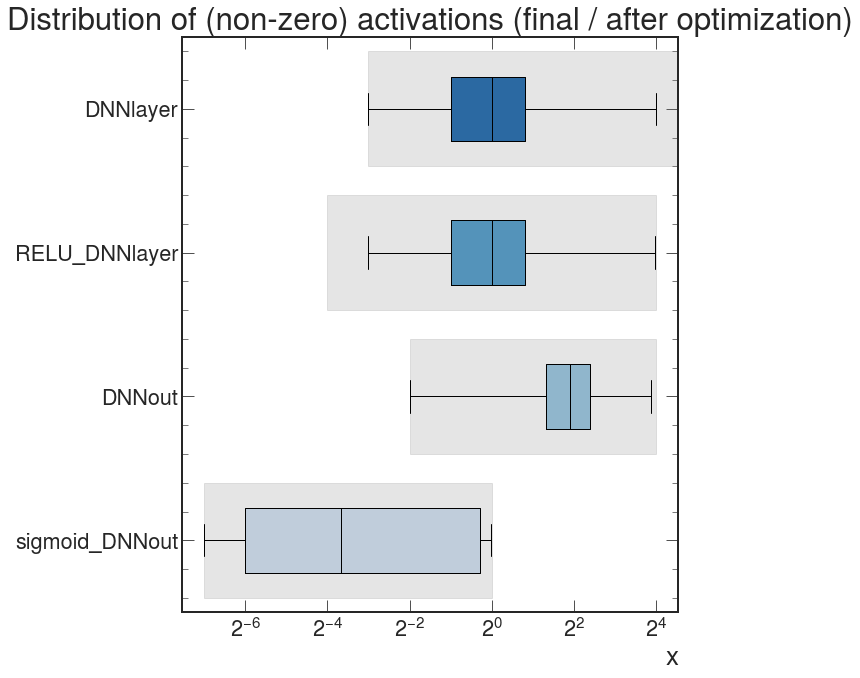

In [9]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

id_QDNN_hls_cfg['LayerName']['CL3DFeatures']['Precision'] = 'ap_fixed<16,6>'

id_QDNN_hls_cfg['LayerName']['DNNlayer']['Precision']['result'] = 'ap_fixed<10,7>'
id_QDNN_hls_cfg['LayerName']['DNNlayer']['Precision']['accum'] = 'ap_fixed<13,5>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<7,5>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<7,5>'

id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_stream'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = identdir+'/TauQDNNIdentifier_HLS/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=np.ascontiguousarray(TensorizedInputIdent_reduced))
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

# Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CL3DFeatures, layer type: Input
Layer name: DNNlayer, layer type: QDense
  -> Activation (linear), layer name: DNNlayer
Layer name: RELU_DNNlayer, layer type: QActivation
  -> Activation (quantized_relu(16,6)), layer name: RELU_DNNlayer
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CL3DFeatures': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer': {'Precision': {'weight': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,9>', 'accum': 'ap_fixed<24,12>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Strategy': 'Resources', 'Trace': True}, 'RELU_DNNlayer': {'Precision': 'ap_fixed<11,7>', 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': Tr

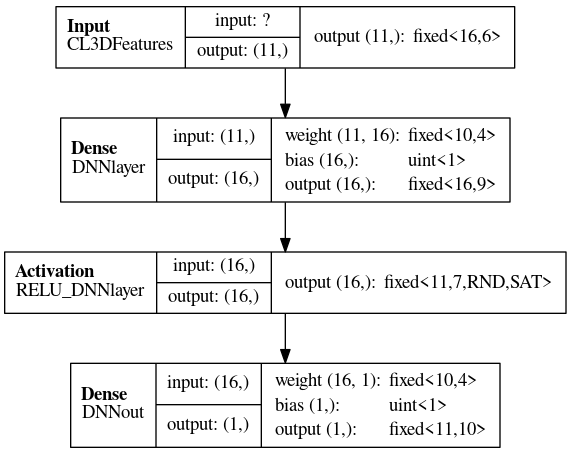

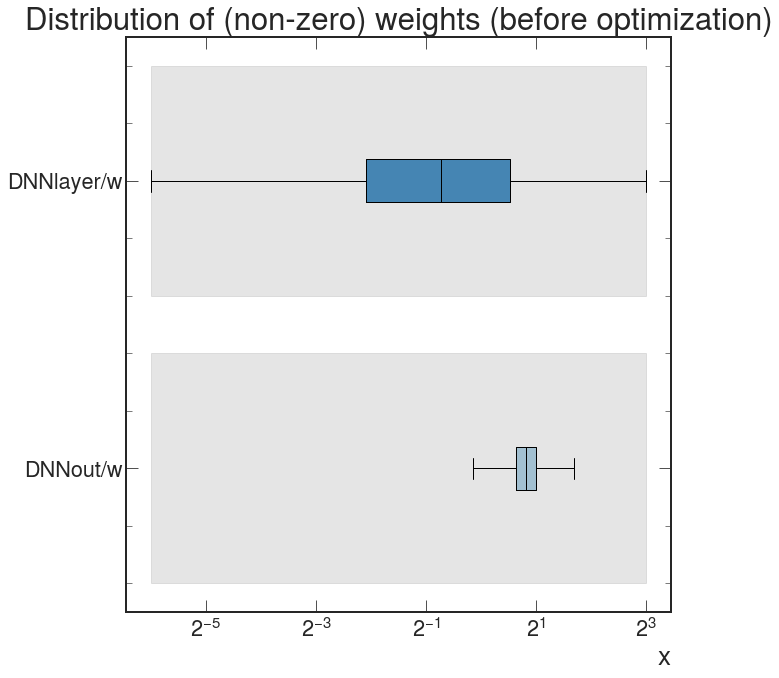

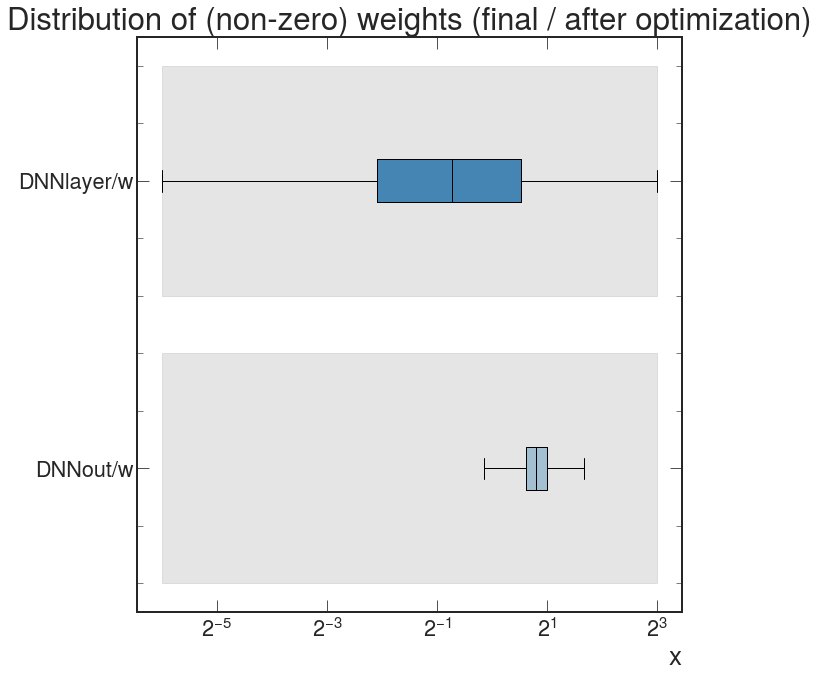

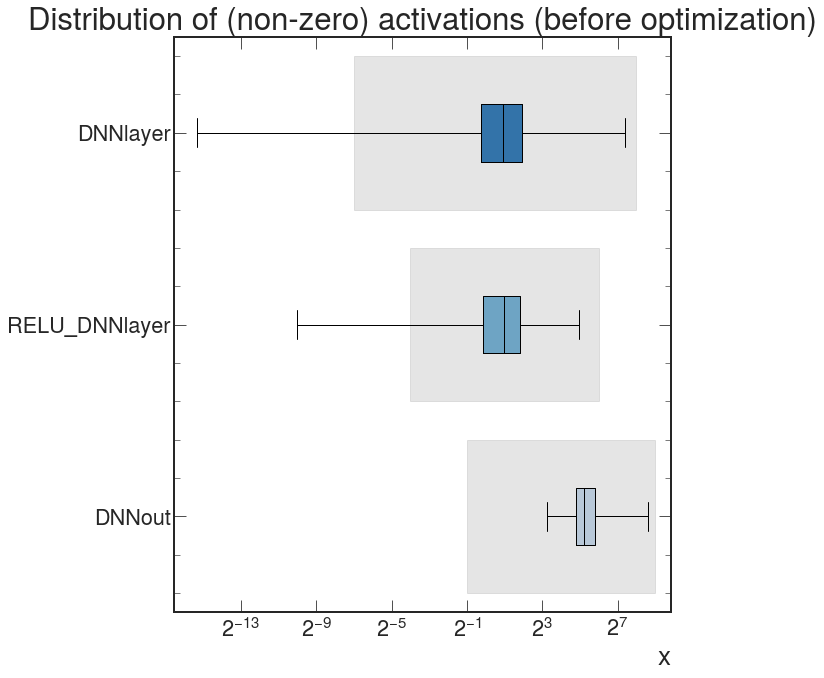

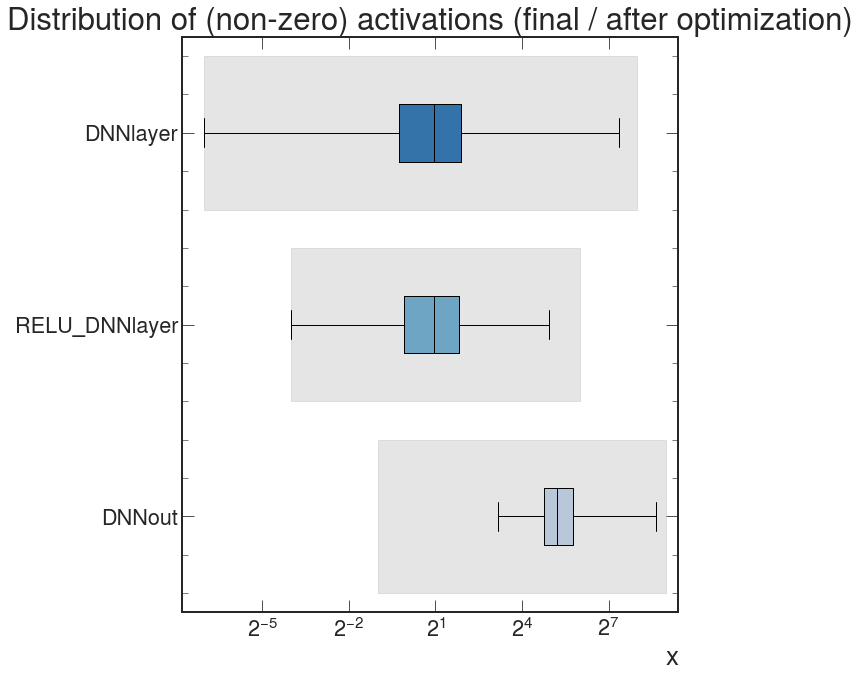

In [41]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CL3DFeatures']['Precision'] = 'ap_fixed<16,6>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer']['Precision']['result'] = 'ap_fixed<16,9>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer']['Precision']['accum'] = 'ap_fixed<24,12>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<24,12>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = calibdir+'/TauQDNNCalibrator_HLS/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=np.ascontiguousarray(TensorizedInputCalib_reduced))
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [12]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Full Float ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [16]:
y_ident_ff = DNNident_FullFloat.predict(TensorizedInputIdent)
y_calib_ff = DNNcalib_FullFloat.predict(TensorizedInputCalib)

In [17]:
y_ident_q        = QDNNident.predict(TensorizedInputIdent)
y_ident_hls4ml_q = QDNNident_hls.predict(np.ascontiguousarray(TensorizedInputIdent))

In [42]:
y_calib_q        = QDNNcalib.predict(TensorizedInputCalib)
y_calib_hls4ml_q = QDNNcalib_hls.predict(np.ascontiguousarray(TensorizedInputCalib))

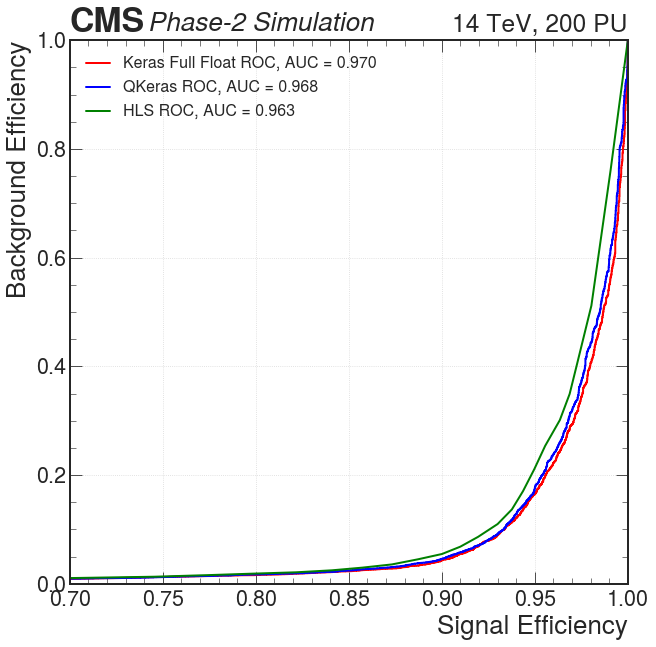

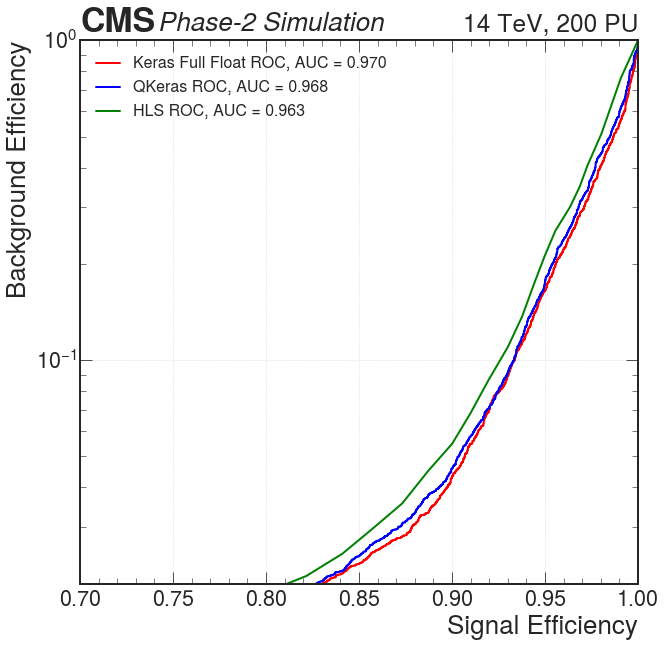

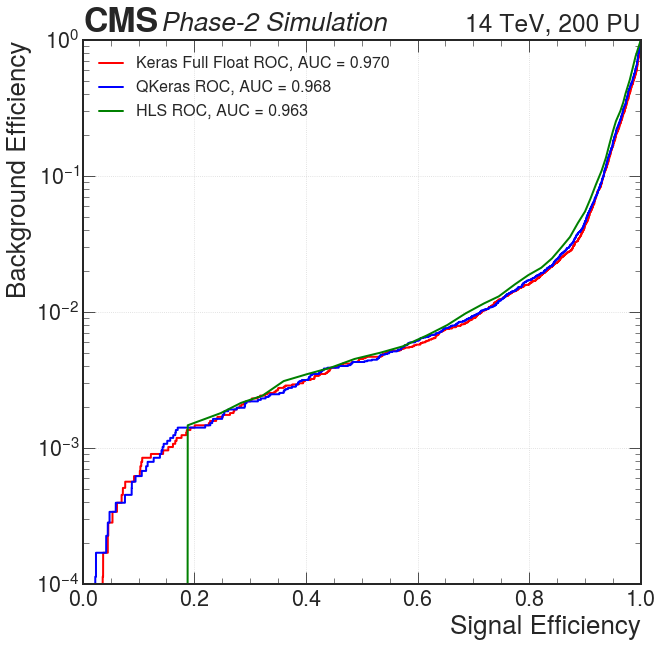

In [19]:
plotROC(TensorizedTargetIdent,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Xrange=(0.7,1), Yrange=(0,1))
plotROC(TensorizedTargetIdent,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(TensorizedTargetIdent,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [43]:
ravelled = TensorizedTargetCalib

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

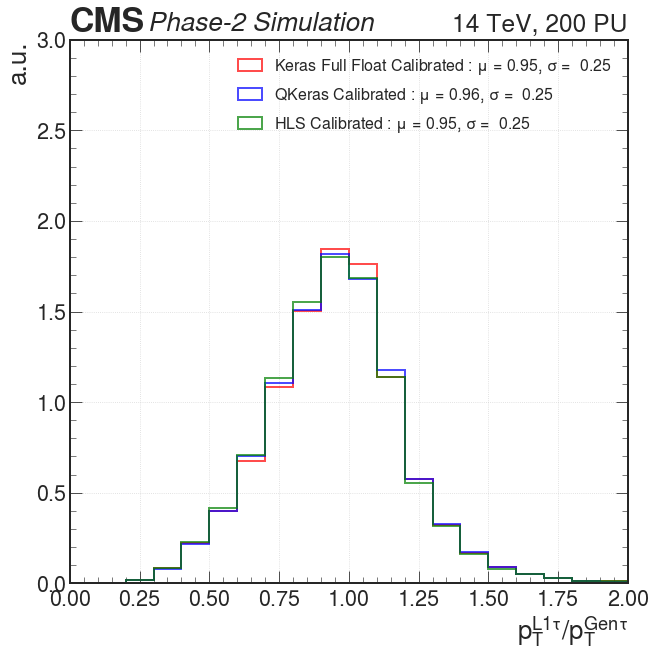

In [44]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Full Float Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE HLS MODELS

In [45]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Oct 06 20:38:17 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.61 seconds; current allocated memory: 349.621 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_array_array_ap_fixed_10_7_5_3_0_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.55 seconds; current allocated memory: 350.116 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring res

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_0_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_1_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_2_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_3_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_4_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CL3DFeatures_V_data_5_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_10_7_5_3_0_16u_config2_s' (5#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_10_7_5_3_0_16u_config2_s.vhd:105]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_16u_relu_config3_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_16u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_16u_relu_config3_U0' of component 'relu_array_array_ap_fixed_16u_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:790]
INFO: [Synth 8-638] synthesizing module 'relu_ar

INFO: [Synth 8-3491] module 'fifo_w9_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/fifo_w9_d1_A.vhd:47' bound to instance 'layer3_out_V_data_12_V_U' of component 'fifo_w9_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:1343]
INFO: [Synth 8-3491] module 'fifo_w9_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/fifo_w9_d1_A.vhd:47' bound to instance 'layer3_out_V_data_13_V_U' of component 'fifo_w9_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNIdentifierTraining_lTauPtCut18_lEtacut1.5/TauQDNNIdentifier_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:04 ; elapsed = 00:00:07 . Memory (MB): peak = 1908.215 ; gain = 284.387 ; free physical = 322262 ; free virtual = 374113
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1914.145 ; gain = 290.316 ; free physical = 322269 ; free virtual = 374120
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_fu_263_p2, operation Mode is: A*(B:0x16).
DSP Report: operator mul_ln1118_fu_263_p2 is absorbed into DSP mul_ln1118_fu_263_p2.
DSP Report: Generating DSP mul_ln1118_13_fu_237_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_13_fu_237_p2 is absorbed into DSP mul_ln1118_13_fu_237_p2.
DSP Report: Generating DSP mul_ln1118_8_fu_354_p2, operation Mode is: A*(B:0x3ffe6).
DSP Report: operator mul_ln1118_8_fu_354_p2 is absor

INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_0_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_10_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_10_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_7_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_7_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_4_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_4_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_1_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_1_V_U/U_fifo_w9_d1_A_shi


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:30 ; elapsed = 00:00:51 . Memory (MB): peak = 2902.051 ; gain = 1278.223 ; free physical = 321243 ; free virtual = 373100
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
--------------------------------------------------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.07 ; elapsed = 00:00:00.07 . Memory (MB): peak = 2910.051 ; gain = 0.000 ; free physical = 321317 ; free virtual = 373174
INFO: [Netlist 29-17] Analyzing 611 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3017.734 ; gain = 0.000 ; free physical = 321210 ; free virtual = 373068
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 202 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 27 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 174 instances

INFO: [Common 17-83] Relea

In [46]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Oct 06 20:40:50 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNCalibratorTraining_lTauPtCut18_lEtacut1.5/TauQDNNCalibrator_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.27 seconds; current allocated memory: 334.245 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,16u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.72 seconds; current allocated memory: 335.893 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architec

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:00:37 ; elapsed = 00:00:49 . Memory (MB): peak = 1305.262 ; gain = 783.172 ; free physical = 322779 ; free virtual = 374694
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h0m46s *****
***** VIVADO SYNTHESIS *****

****** Vivado v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source vivado_synth.tcl
# add_files myproject_prj/solution1/syn/vhdl
# synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Command: synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Starting synth_design
Attempting to get a license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: [Common 17-349] Got license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: Launching helper process 

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_11_10_5_3_0_1u_config4_s' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNCalibratorTraining_lTauPtCut18_lEtacut1.5/TauQDNNCalibrator_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_11_10_5_3_0_1u_config4_s.vhd:75]
INFO: [Synth 8-3491] module 'fifo_w16_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNCalibratorTraining_lTauPtCut18_lEtacut1.5/TauQDNNCalibrator_HLS/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:47' bound to instance 'layer2_out_V_data_0_V_U' of component 'fifo_w16_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNCalibratorTraining_lTauPtCut18_lEtacut1.5/TauQDNNCalibrator_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:902]
INFO: [Synth 8-638] synthesizing module 'fifo_w16_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauDNNCalibratorTraining_lTauPtCut18_lEtacut

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:07 . Memory (MB): peak = 1908.098 ; gain = 283.395 ; free physical = 322202 ; free virtual = 374119
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1919.965 ; gain = 295.262 ; free physical = 322204 ; free virtual = 374121
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_11_fu_399_p2, operation Mode is: A*(B:0x3d).
DSP Report: operator mul_ln1118_11_fu_399_p2 is absorbed into DSP mul_ln1118_11_fu_399_p2.
DSP Report: Generating DSP mul_ln1118_65_fu_430_p2, operation Mode is: A*(B:0x17).
DSP Report: operator mul_ln1118_65_fu_430_p2 is absorbed into DSP mul_ln1118_65_fu_430_p2.
DSP Report: Generating DSP mul_ln1118_fu_418_p2, operation Mode is: A*(B:0xb7).
DSP Report: operator mul_ln1118_fu_418_p2 is absorb

DSP Report: Generating DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_10_fu_207_p2, operation Mode is: A2*(B:0x64).
DSP Report: register data_14_V_reg_458_reg is absorbed into DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_10_fu_207_p2.
DSP Report: operator grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_10_fu_207_p2 is absorbed into DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_10_fu_207_p2.
DSP Report: Generating DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_4_fu_218_p2, operation Mode is: A2*(B:0x3a).
DSP Report: register data_6_V_reg_418_reg is absorbed into DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_4_fu_218_p2.
DSP Report: operator grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_config4_s_fu_299/mul_ln728_4_fu_218_p2 is absorbed into DSP grp_dense_wrapper_ap_fixed_ap_fixed_11_10_5_3_0_confi

---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:00:30 ; elapsed = 00:00:51 . Memory (MB): peak = 2901.172 ; gain = 1276.469 ; free physical = 321172 ; free virtual = 373097
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-----------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                          | DSP Mapping   | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+---------------------------------------------


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:30 ; elapsed = 00:00:51 . Memory (MB): peak = 2901.176 ; gain = 1276.473 ; free physical = 321172 ; free virtual = 373097
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
--------------------------------------------------

Synthesis Optimization Complete : Time (s): cpu = 00:00:36 ; elapsed = 00:00:57 . Memory (MB): peak = 2901.180 ; gain = 1276.473 ; free physical = 321174 ; free virtual = 373098
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.09 ; elapsed = 00:00:00.10 . Memory (MB): peak = 2916.113 ; gain = 0.000 ; free physical = 321243 ; free virtual = 373168
INFO: [Netlist 29-17] Analyzing 884 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3044.797 ; gain = 0.000 ; free physical = 321116 ; free virtual = 373040
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 286 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_